In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rc
import matplotlib.ticker as ticker
from matplotlib import rc
from scipy.stats import norm
from scipy.special import factorial
from scipy.special import gammaln
from tqdm import tqdm
import scipy.optimize as spo

In [28]:
# Matplotlib customize
plt.rcParams['figure.figsize'] = [6,5]
plt.rcParams['figure.dpi'] = 100

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20

plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 4

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.markerscale'] = 1.5
plt.rcParams['legend.borderpad'] = 0.6
plt.rcParams['legend.framealpha'] = 0.7

In [29]:
# Reading channels
data = pd.read_csv('datos.csv',sep=',')
n = np.array(data.n)
b = np.array(data.b)
s = np.array(data.s)
N = n.shape[0]
data

,n,b,s
0,105,100,10


In [30]:
def LogLikelihood(n,b,s,mu):
    
    lambda_ = mu*s + b
    
    log_likelihood = -lambda_ + n * np.log(lambda_) - gammaln(n+1)
    
    return log_likelihood

In [31]:
def GetJointLogLikelihood(mu,Expected=True):
    
    JointLog = 0.
    
    for c in range(N):
        
        if Expected:
            JointLog += LogLikelihood(b[c],b[c],s[c],mu)
        else:
            JointLog += LogLikelihood(n[c],b[c],s[c],mu)
            
    return -JointLog

In [32]:
mu = np.linspace(0.,2.,20)
LogLike = GetJointLogLikelihood(mu,Expected=False)

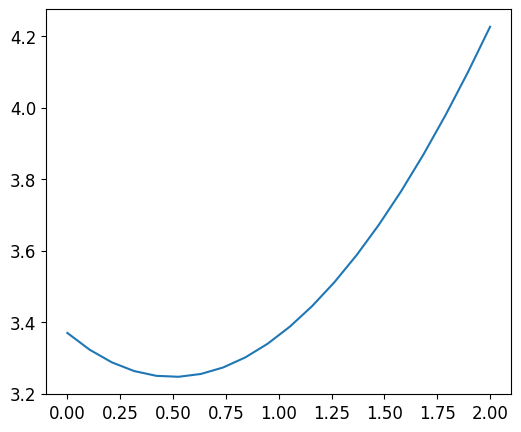

In [33]:
plt.plot(mu,LogLike)

In [34]:
# Minimizando el log-likelihood
mu0 = 1.
result = spo.minimize( GetJointLogLikelihood, mu0, args=(False), options={"disp":True}, method='Nelder-Mead' )

muhat = 0.
if result.success:
    print('Maximum found')
    muhat = result.x[0]
else:
    print('Maximum no found - SETPOI')

Optimization terminated successfully.
         Current function value: 3.246712
         Iterations: 15
         Function evaluations: 30
Maximum found


In [35]:
muhat

0.49999999999999956

In [36]:
def qm(mu,muhat,Expected=False):
    
    if mu >= muhat:
        return 2*(GetJointLogLikelihood(mu) - GetJointLogLikelihood(muhat) ) 
    else:
        return 0.

In [37]:
qm(0.6,muhat)

0.10425120909121688